In [1]:
# install tables (missing from SWAN stack)
!pip install tables --user
import sys
sys.path.append('$CERNBOX_HOME/.local/lib/python2.7/site-packages')
# restart notebook after this step (only needed once)!

    100% |████████████████████████████████| 4.3MB 6.4MB/s eta 0:00:01
tensorflow 1.12.0 requires backports.weakref>=1.0rc1, which is not installed.
py2neo 4.0.0 requires colorama, which is not installed.
py2neo 4.0.0 requires neo4j-driver>=1.6.0, which is not installed.
keras 2.2.0 has requirement keras_applications==1.0.2, but you'll have keras-applications 1.0.6 which is incompatible.
keras 2.2.0 has requirement keras_preprocessing==1.0.1, but you'll have keras-preprocessing 1.0.5 which is incompatible.
  The scripts pt2to3, ptdump, ptrepack and pttree are installed in '/eos/user/w/woodson/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import keras
import numpy as np
import tables
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# 27 features
features = ['fj_jetNTracks',
            'fj_nSV',
            'fj_tau0_trackEtaRel_0',
            'fj_tau0_trackEtaRel_1',
            'fj_tau0_trackEtaRel_2',
            'fj_tau1_trackEtaRel_0',
            'fj_tau1_trackEtaRel_1',
            'fj_tau1_trackEtaRel_2',
            'fj_tau_flightDistance2dSig_0',
            'fj_tau_flightDistance2dSig_1',
            'fj_tau_vertexDeltaR_0',
            'fj_tau_vertexEnergyRatio_0',
            'fj_tau_vertexEnergyRatio_1',
            'fj_tau_vertexMass_0',
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [3]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    h5file.close()
    return feature_array, label_array

In [4]:
# copy training file if it doesn't exist
import os.path
if not os.path.isfile('ntuple_merged_10.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .

# load training file
feature_array, label_array = get_features_labels('ntuple_merged_10.h5', remove_mass_pt_window=False)

190517 20:31:53 368 secgsi_InitProxy: cannot access private key file: /eos/user/w/woodson/.globus/userkey.pem
[1.403GB/1.403GB][100%][==================================================][102.6MB/s]  


In [5]:
# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 27)                0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 27)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1792      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 5,102
Trainable params: 5,048
Non-trainable params: 54
_________________________________________________________________
None


In [6]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=100, validation_split=0.2, shuffle=False,
                callbacks = callbacks)

Train on 150255 samples, validate on 37564 samples
Epoch 1/100
150255/150255 [==============================] - 2s 15us/step - loss: 0.2939 - acc: 0.8945 - val_loss: 0.2455 - val_acc: 0.9052
Epoch 2/100
150255/150255 [==============================] - 2s 12us/step - loss: 0.2390 - acc: 0.9084 - val_loss: 0.2395 - val_acc: 0.9075
Epoch 3/100
150255/150255 [==============================] - 2s 12us/step - loss: 0.2339 - acc: 0.9102 - val_loss: 0.2364 - val_acc: 0.9087
Epoch 4/100
150255/150255 [==============================] - 2s 12us/step - loss: 0.2309 - acc: 0.9112 - val_loss: 0.2344 - val_acc: 0.9092
Epoch 5/100
150255/150255 [==============================] - 2s 12us/step - loss: 0.2289 - acc: 0.9118 - val_loss: 0.2329 - val_acc: 0.9092
Epoch 6/100
150255/150255 [==============================] - 2s 12us/step - loss: 0.2273 - acc: 0.9124 - val_loss: 0.2318 - val_acc: 0.9095
Epoch 7/100
150255/150255 [==============================] - 2s 12us/step - loss: 0.2260 - acc: 0.9132 - val_

In [7]:
# copy testing file if it doesn't exist
import os.path
if not os.path.isfile('ntuple_merged_0.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.h5 .
        
# load testing file
feature_array_test, label_array_test = get_features_labels('ntuple_merged_0.h5')

190517 20:33:37 489 secgsi_InitProxy: cannot access private key file: /eos/user/w/woodson/.globus/userkey.pem
[1.403GB/1.403GB][100%][==================================================][102.6MB/s]  


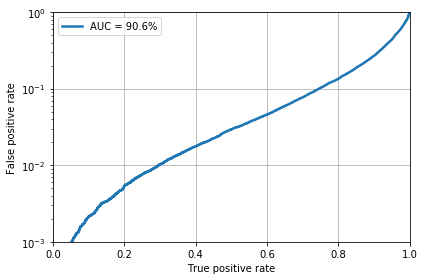

In [8]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')